# Телеком — Определение неэффективных операторов

### Задача:

Помогите «Нупозвони» найти самых неэффективных операторов. Признаки низкой эффективности:

- *много пропущенных входящих вызовов*
- *долгое ожидания ответа при входящих внешних вызовах*
- *мало исходящих вывозов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков*

### *Подготовка к анализу данных*
#### *Импорт нужных библиотек*

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from scipy import stats as st

from datetime import datetime
from datetime import date
from datetime import timedelta

#### *Загрузка датасетов*

In [15]:
try:
    df_clients = pd.read_csv('telecom_clients.csv')
    df_dataset = pd.read_csv('telecom_dataset.csv')
except:
    df_clients = pd.read_csv('/datasets/telecom_clients.csv')
    df_dataset = pd.read_csv('/datasets/telecom_dataset.csv')   

pd.set_option('precision', 2)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#### *Краткий взгляд на данные*

In [16]:
display(df_clients.head(), df_dataset.head())

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.000,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.000,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.000,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.000,True,3,0,25


#### *Описание данных*

***Датасеты описывают использование услуг «Нупозвони» — провайдера виртуальный телефонии. Его клиенты — колл-центры, которые:***

- *распределяют входящие вызовы на операторов,*
- *совершают исходящие вызовы силами операторов.*

*Также операторы могут делать внутренние вызовы —  вызовы друг между другом внутри сети виртуальной телефонии.*

***Колонки в `telecom_dataset.csv.zip`:***

- `user_id` — Идентификатор клиентского аккаунта в сервисе
- `date` — Дата статистики
- `direction` — Направление вызовов (out - исходящий вызов, in — входящий вызов)
- `internal` — Является ли звонок внутренним звонком между операторами клиента
- `operator_id` — Идентификатор оператора
- `is_missed_call` — Является ли звонок пропущенным
- `calls_count` — Количество звонков
- `call_duration` — Длительность звонка (без учета времени ожидания)
- `total_call_duration` — Длительность звонка (с учетом времени ожидания)

***Колонки в `telecom_clients.csv`:***

- `user_id` — Идентификатор клиентского аккаунта в сервисе
- `tariff_plan` — Текущий тарифный план клиента
- `date_start` — Дата регистрации клиента в сервисе

#### *Промежуточные выводы:*
* *На первый взгляд данные кажутся чистыми, где-то есть пропуски, видим, что есть довольно много информации и колонок, будет приятно работать дальше.*

### *Предобработка данных*

#### *Названия столбцов*
*Названия столбцов в хорошем нижнем регистре в snake_case, поэтому можно оставить как есть.*

#### *Типы данных в столбцах*

In [17]:
print('Типы данных в df_clients:')
display(df_clients.dtypes)
print('Типы данных в df_dataset:')
display(df_dataset.dtypes)

Типы данных в df_clients:


user_id         int64
tariff_plan    object
date_start     object
dtype: object

Типы данных в df_dataset:


user_id                  int64
date                    object
direction               object
internal                object
operator_id            float64
is_missed_call            bool
calls_count              int64
call_duration            int64
total_call_duration      int64
dtype: object

***какие типы в столбцах будем менять:***

* ***`date_start`:*** *object* --> *datetime*
* ***`date`:*** *object* --> *datetime*
* ***`internal`:*** *object* --> *bool*
* ***`operator_id`:*** *float64* --> *int64*

In [18]:
df_clients['date_start'] = pd.to_datetime(df_clients['date_start'])

df_dataset['date'] = pd.to_datetime(df_dataset['date']).dt.date
df_dataset['date'] = pd.to_datetime(df_dataset['date'])

df_dataset['internal'] = df_dataset['internal'].astype(bool)
df_dataset['operator_id'] = df_dataset['operator_id'].astype('int64', errors = 'ignore')

#### *Дубликаты*

In [19]:
print(f'Процент дубликатов в df_clients: {round(df_clients.duplicated().sum() / df_clients.shape[0] * 100,4)}%')
print(f'Процент дубликатов в df_dataset: {round(df_dataset.duplicated().sum() / df_dataset.shape[0] * 100,4)}%')

Процент дубликатов в df_clients: 0.0%
Процент дубликатов в df_dataset: 9.0906%


In [20]:
# избавляемся от дубликатов
df_dataset = df_dataset.drop_duplicates().reset_index(drop = True)

#### *Пропущенные значения*

In [21]:
print('Пропуски в df_clients:')
display(df_clients.isna().sum())
print('Пропуски в df_dataset:')
display(df_dataset.isna().sum())

Пропуски в df_clients:


user_id        0
tariff_plan    0
date_start     0
dtype: int64

Пропуски в df_dataset:


user_id                   0
date                      0
direction                 0
internal                  0
operator_id            7456
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [22]:
# посмотрим внимательнее на пропуске в operator_id
display(df_dataset[df_dataset.operator_id.isna() == True].head())
nans = round(df_dataset[df_dataset.operator_id.isna() == True].shape[0] / df_dataset.shape[0] * 100, 2)
print(f'Процент пропусков в df_dataset: {nans}%')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,NaN,True,2,0,4
7,166377,2019-08-05,in,False,NaN,True,6,0,35
8,166377,2019-08-06,in,False,NaN,True,4,0,62
16,166377,2019-08-07,in,False,NaN,True,2,0,24
26,166377,2019-08-12,in,False,NaN,True,2,0,34


Процент пропусков в df_dataset: 15.22%


In [23]:
# заполним пропуски нулями, чтобы не потерять аж 15.22% данных

df_dataset['operator_id'] = df_dataset['operator_id'].fillna(0)

#### *Аномальные значения*

In [24]:
descriptions = (df_dataset.describe(percentiles = [.05, .25, .50, .75, .90, .95, .96, .97, .98, .99])
                          .drop(columns = ['user_id', 'operator_id']))
display(descriptions)

,calls_count,call_duration,total_call_duration
count,49002.000,49002.000,49002.000
mean,16.463,866.282,1156.558
std,63.604,3775.503,4451.474
min,1.000,0.000,0.000
5%,1.000,0.000,3.000
25%,1.000,0.000,46.000
50%,4.000,37.000,208.000
75%,12.000,570.000,901.000
90%,35.000,2092.000,2610.800
95%,62.000,3725.950,4531.000


In [25]:
# уберем 1% аномальных значений из каждого столбца
df_dataset = df_dataset.query('calls_count <= @descriptions.calls_count[-2]')
df_dataset = df_dataset.query('call_duration <= @descriptions.call_duration[-2]')
df_dataset = df_dataset.query('total_call_duration <= @descriptions.total_call_duration[-2]')

***Итоги предобработки данных:***
1. *Заменили типы данных в некоторых столбцах*
2. *Избавились от дубликатов в `df_dataset`, в `df_clients` дубликатов не оказалось*
3. *Пропусков оказалось 15%, заполнили нулями, чтобы не потерять большую часть данных*
4. *Убрали 1% аномальных значений в `df_dataset`*

---
### *Исследовательский анализ данных*

#### *Проанализируем датасет `df_clients`*

In [26]:
print(f'Количество клиентов каждого тарифного плана:')
display(df_clients.tariff_plan.value_counts().to_frame().rename(columns = {'tariff_plan' : 'count'}))

Количество клиентов каждого тарифного плана:


,count
C,395
B,261
A,76


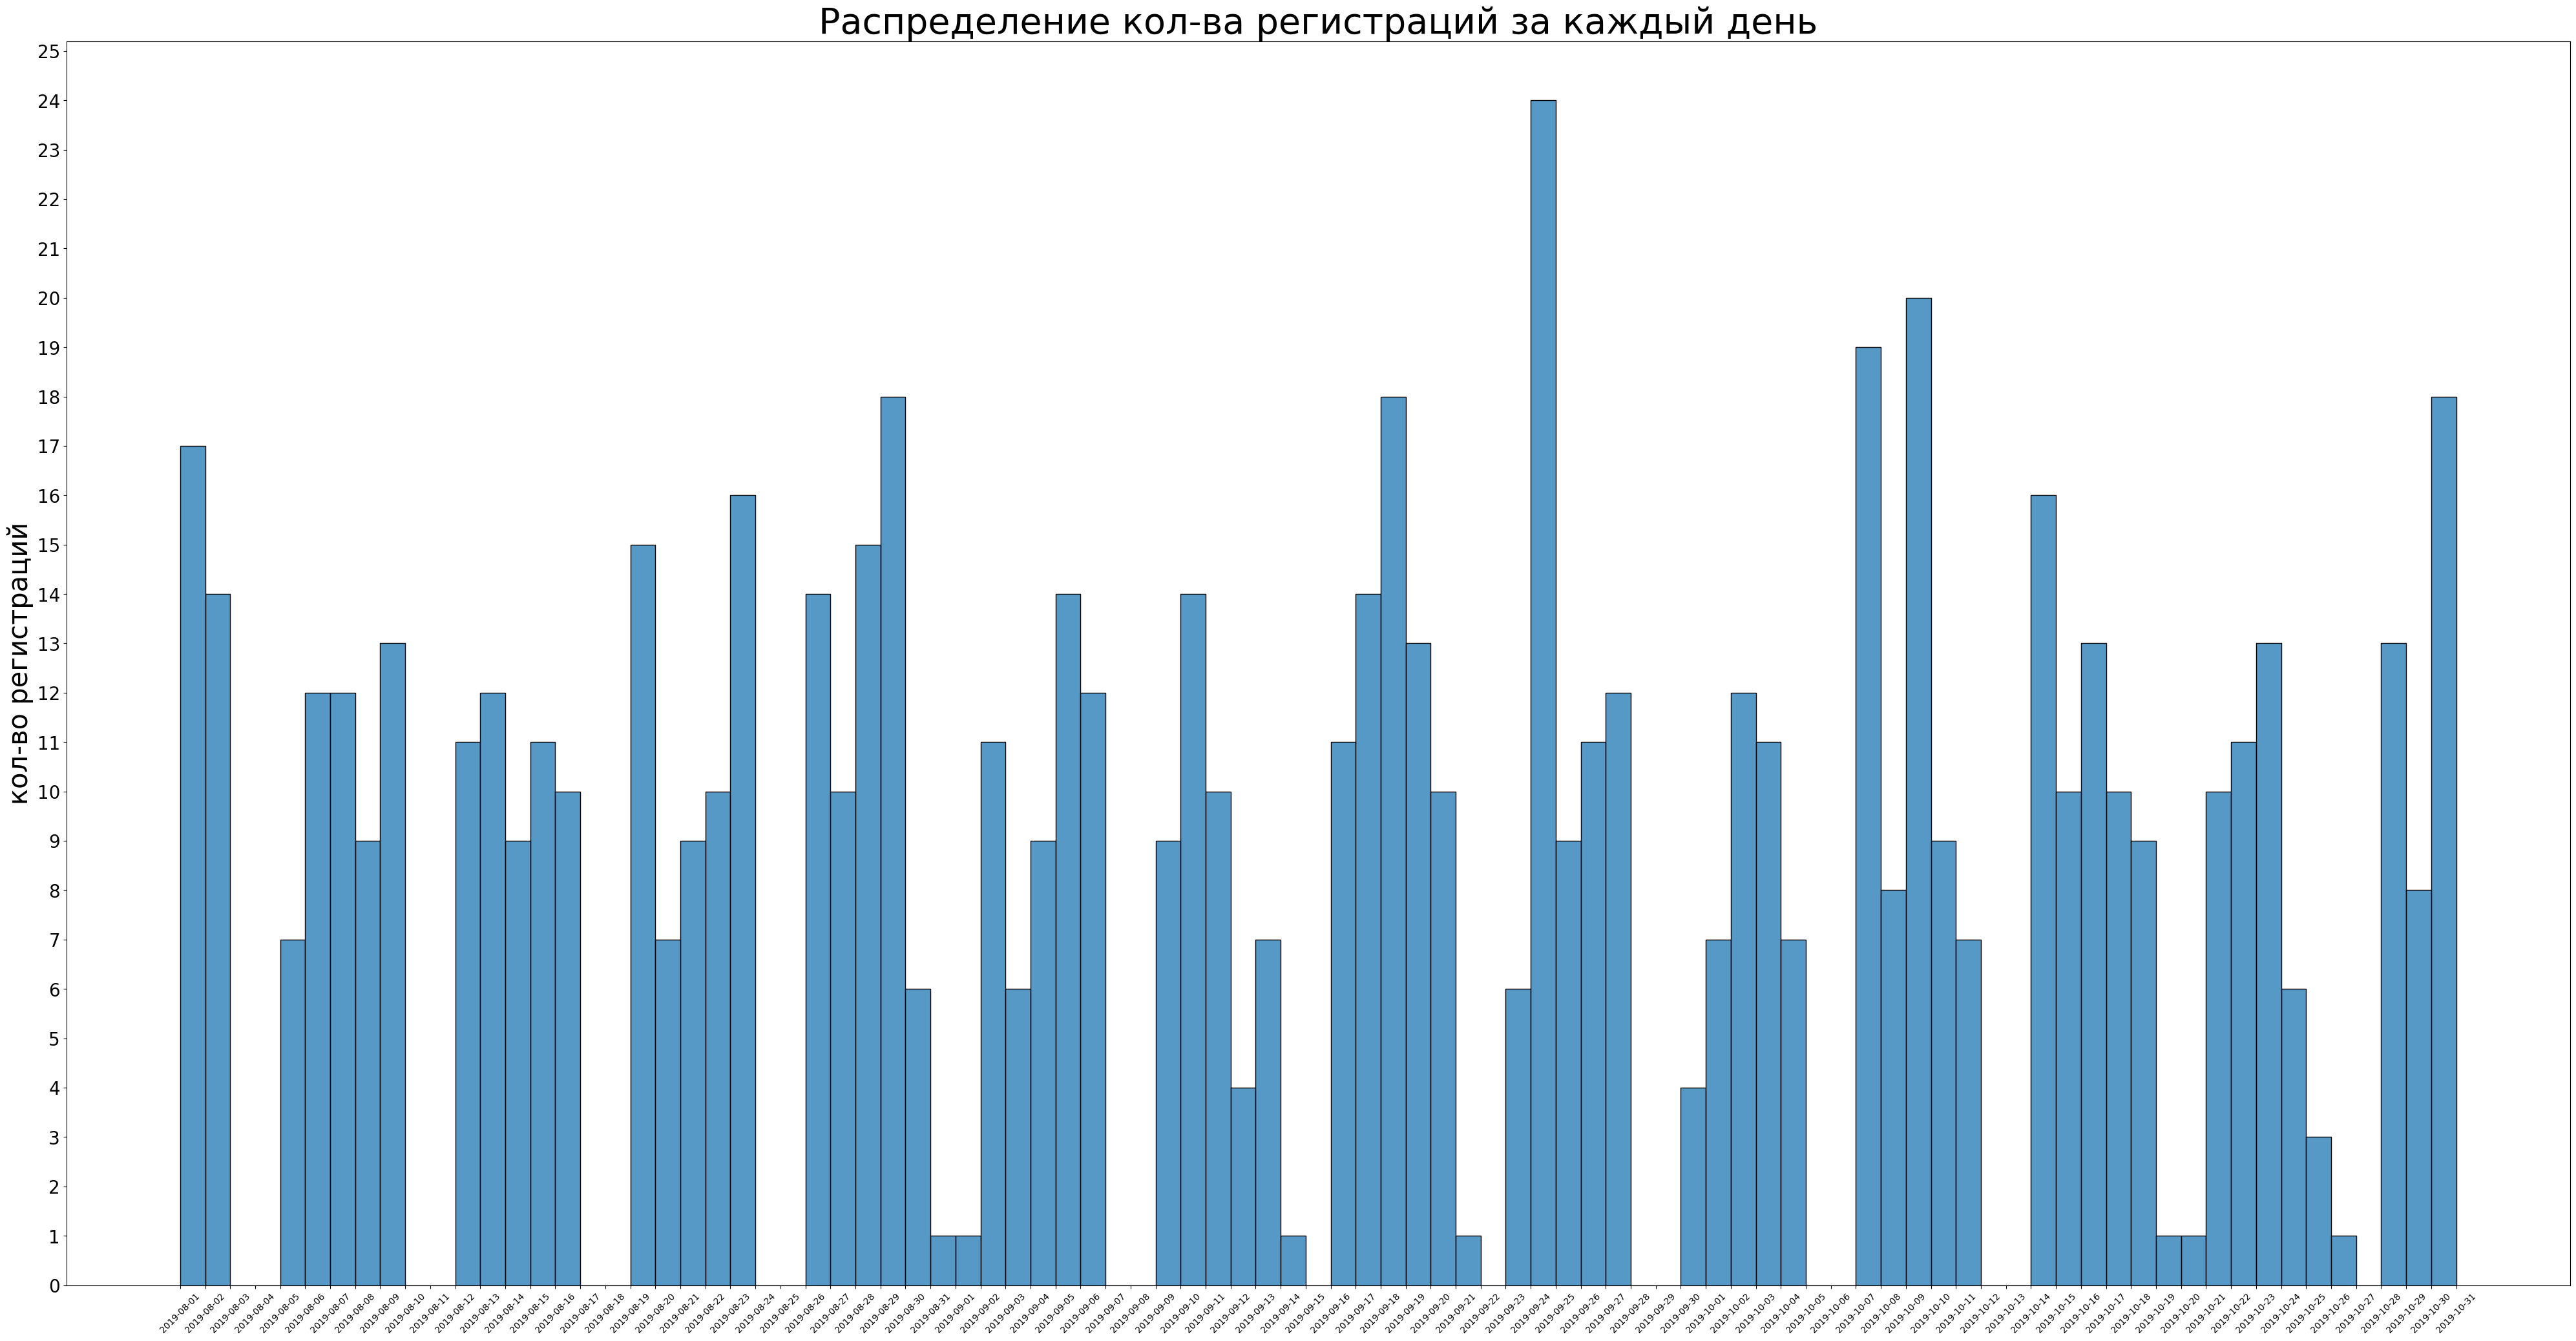

In [27]:
plt.figure(figsize = (50,25))

sns.histplot(data = df_clients, x = 'date_start', bins = 91)

plt.xticks(np.arange(datetime(2019,8,1), datetime(2019,11,1), timedelta(days = 1)), rotation = 45)
plt.xlabel('')

plt.yticks(np.arange(0,26,1), size = 20)
plt.ylabel('кол-во регистраций', size = 30)

plt.title('Распределение кол-ва регистраций за каждый день', size = 40)

plt.show()

***промежуточные выводы:***
- *Больше всего клиентов у тарифа С, потом тариф B, потом А.*
- *Можно пронаблюдать, что в основном все регистрации происходят с понедельника по пятницу, а в выходные регистраций либо нет, либо слишком мало (1-2 штуки).*

In [28]:
# создаем столбцы, чтобы посмотреть поближе на кол-во пользователей по датам

df_clients['month'] = df_clients['date_start'].dt.month
df_clients['weekday'] = df_clients['date_start'].dt.weekday

In [29]:
print('Кол-во пользователей каждый месяц:')
display(df_clients.groupby('month', as_index = False).user_id.count().rename(columns = {'user_id' : 'users_amount'}))
print('\n Кол-во пользователей в каждый день недели:')
display(df_clients.groupby('weekday', as_index = False).user_id.count().rename(columns = {'user_id' : 'users_amount'}))

Кол-во пользователей каждый месяц:


,month,users_amount
0,8,258
1,9,231
2,10,243



 Кол-во пользователей в каждый день недели:


,weekday,users_amount
0,0,146
1,1,143
2,2,155
3,3,155
4,4,126
5,5,5
6,6,2


***промежуточные выводы:***
- *кол-во пользователей в каждый месяц примерно одинаково*
- *кол-во пользователей на выходных значительно меньше.*

In [30]:
# создаем сводную таблицу, где группируем кол-во пользователей по дню недели и тарифному плану
weekday_tariffs = (df_clients.groupby(['weekday', 'tariff_plan'], as_index = False)
                             .user_id
                             .count()
                             .rename(columns = {'user_id' : 'amount_users'}))

# записываем кол-во пользователей в каждой группе
a_users = df_clients.query('tariff_plan == "A"').shape[0]
b_users = df_clients.query('tariff_plan == "B"').shape[0]
c_users = df_clients.query('tariff_plan == "C"').shape[0]

# ф-я для получения процента пользователей в каждой группе
def percentage_rate(row):
    if row['tariff_plan'] == 'A': return row['amount_users'] / a_users
    if row['tariff_plan'] == 'B': return row['amount_users'] / b_users
    if row['tariff_plan'] == 'C': return row['amount_users'] / c_users
    return 'NaN';

In [31]:
weekday_tariffs['rate'] = weekday_tariffs.apply(percentage_rate, axis = 1)

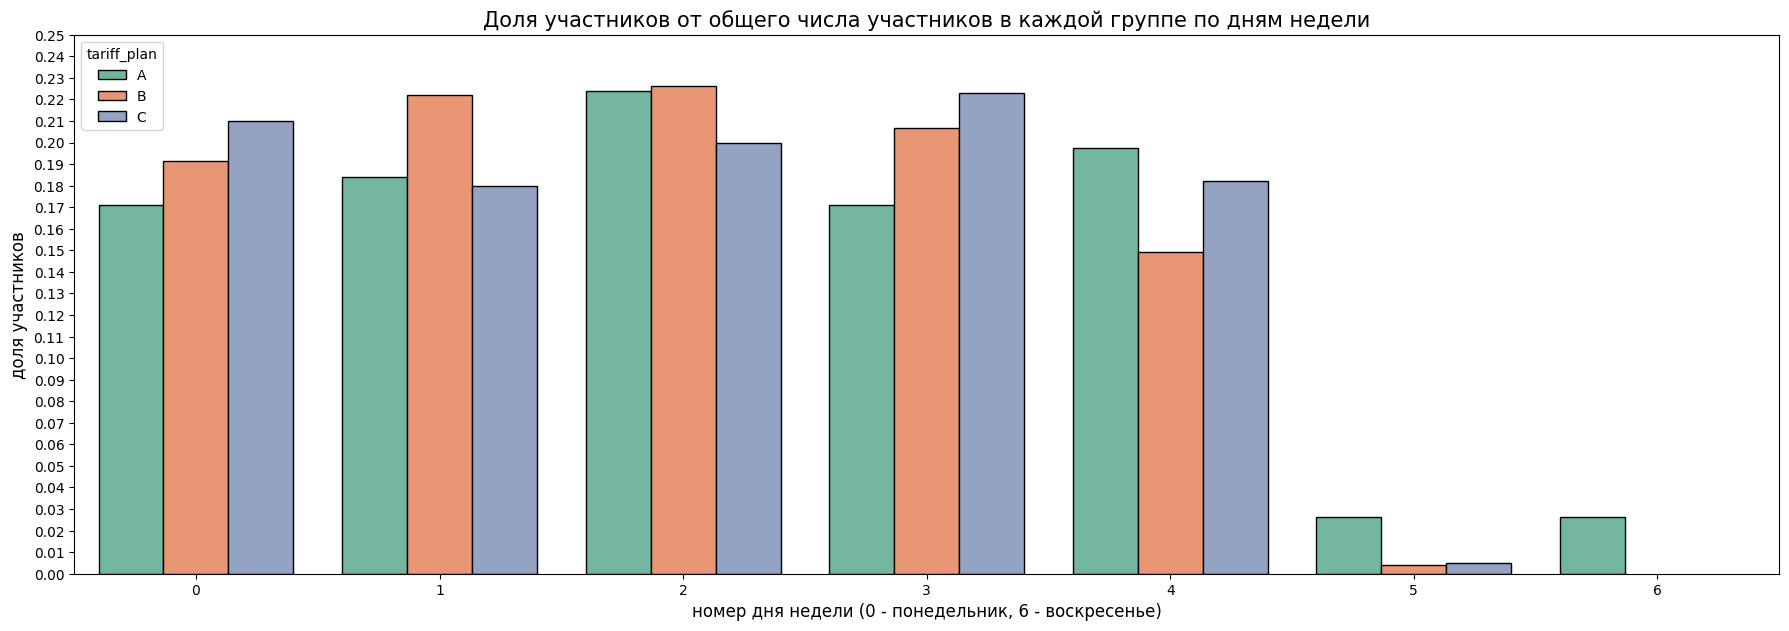

In [32]:
plt.figure(figsize = (22,7))

sns.barplot(data = weekday_tariffs, x = 'weekday', y = 'rate', hue = 'tariff_plan', palette = 'Set2', edgecolor = 'black')

plt.title('Доля участников от общего числа участников в каждой группе по дням недели', size = 15)

plt.xlabel('номер дня недели (0 - понедельник, 6 - воскресенье)', size = 12)
plt.ylabel('доля участников', size = 12)

plt.yticks(np.arange(0, 0.26, 0.01))

plt.show()

***промежуточные выводы:***

- *у группы А больше активности в среду и пятницу, в остальные дни примерно одинаково (не считаем выходные)*
- *у группы B меньше всего активности в пятницу, в остальные дни примерно одинаково (не считаем выходные)*
- *у группы C больше всего активности в четверг и понедельник, в остальные дни примерно одинаково (не считаем выходные)*

#### *сделаем 1 общий датасет, чтобы исследовать звонки*

In [34]:
# объединяем 2 датасета, чтобы получить дату регистрацию и группу, из которой пришел пользователь

main_df = df_dataset.merge(df_clients[['user_id', 'tariff_plan', 'date_start']], how = 'left', on = 'user_id')
display(main_df.head())

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,tariff_plan,date_start
0,166377,2019-08-04,in,False,0.000,True,2,0,4,B,2019-08-01
1,166377,2019-08-05,out,True,880022.000,True,3,0,5,B,2019-08-01
2,166377,2019-08-05,out,True,880020.000,True,1,0,1,B,2019-08-01
3,166377,2019-08-05,out,True,880020.000,False,1,10,18,B,2019-08-01
4,166377,2019-08-05,out,False,880022.000,True,3,0,25,B,2019-08-01


***Итоги исследовательского анализа данных:***
1. *Посчитали кол-во клиентов каждого тарифного плана, С > B > A*
2. *Выяснили, что почти все регистрации совершаются в будние дни*
3. *Посчитали доли участников каждого тарифного плана по дням недели, выяснили что у разных тарифов преобладают регистрации в разные дни недели*

---
### *Определение неэффективных операторов*

**Есть следующие критерии неэффективности:**

- *много пропущенных входящих вызовов*
- *долгое ожидания ответа при входящих внешних вызовах*
- *мало исходящих вывозов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков*

**Разберём каждый критерий отдельно и определим неэффективных операторов.**

***1. пропущенные входящие вызовы***

In [35]:
# 1. для каждого оператора определим общее кол-во входящих вызовов

temp1 = (main_df.query('direction == "in" and operator_id != 0')
                .groupby('operator_id', as_index = False)
                .user_id
                .count()
                .rename(columns = {'user_id' : 'in_calls_amount'})
                .sort_values(by = 'in_calls_amount', ascending = False))

# 2. для каждого оператора определим кол-во пропущенных входящих вызовов

temp2 = (main_df.query('direction == "in" and operator_id != 0 and is_missed_call == True')
                .groupby('operator_id', as_index = False)
                .user_id
                .count()
                .rename(columns = {'user_id' : 'missed_in_calls_amount'})
                .sort_values(by = 'missed_in_calls_amount', ascending = False))

# 3. объединяем в 1 датасет, считаем долю

missed_in_calls = temp1.merge(temp2, how = 'inner', on  = 'operator_id')
missed_in_calls['missed_in_calls_ratio'] = missed_in_calls['missed_in_calls_amount'] / missed_in_calls['in_calls_amount']
missed_in_calls.sort_values(by = 'missed_in_calls_ratio', ascending = False, inplace = True)

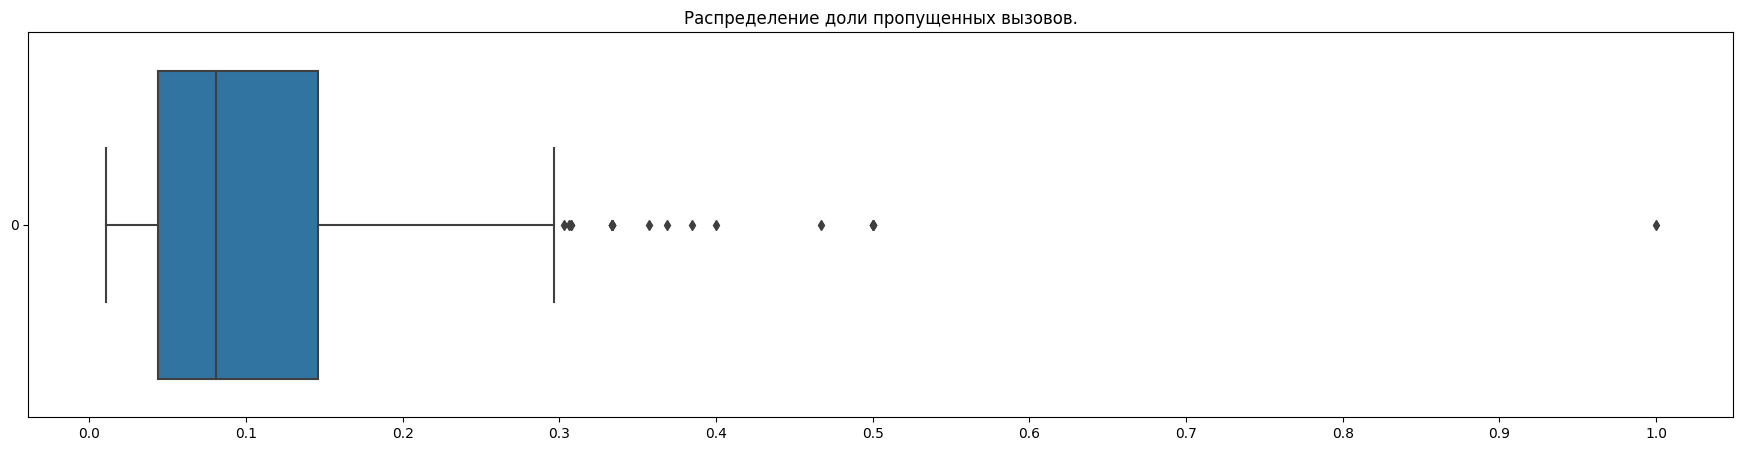

In [36]:
plt.figure(figsize = (22, 5))

sns.boxplot(data = missed_in_calls.missed_in_calls_ratio, orient = 'h')
plt.xticks(np.arange(0,1.1,0.1))
plt.title('Распределение доли пропущенных вызовов.')

plt.show()

*Как сказано [здесь](https://www.freshworks.com/freshcaller-cloud-pbx/call-center-software/call-abandonment-rate-blog/), операторов можно считать эффективными, если пропущено до 5-8% от общего кол-ва звонков, максимум до 20%, поэтому выделим неэффективных операторов.*

In [37]:
# создаём список с неэффективными операторами, потом будем добавлять в него операторов еще и по другому критерию

inefficient_operators = list(missed_in_calls.query('missed_in_calls_ratio > 0.2').operator_id)

***2. долгое ожидания ответа при входящих внешних вызовах***

*Есть стандарт, говорящий, что на 80% звонков должен поступить ответ в течение либо 20 секунд (более точное), либо 60 секунд (менее точное оценивание). Давайте возьмем аналогичный пример, если медианное время на все звонки не превышает 60 секунд, то мы будем считать этого оператора эффективным.*

In [46]:
# 1. создадим колонку со временем ожидания ответа
main_df['response_waiting_time'] = main_df['total_call_duration'] - main_df['call_duration']
main_df['average_response_waiting_time'] = main_df['response_waiting_time'] / main_df['calls_count']

# 2. считаем медианное значение по ожиданию ответа, медианное, потому что более устойчивое к выбросам
time_to_response = (main_df.query('direction == "in" and operator_id != 0 and internal == False')
                           .groupby('operator_id', as_index = False)
                           .average_response_waiting_time
                           .median()
                           .rename(columns = {'average_response_waiting_time' : 'median_response_waiting_time'})
                           .sort_values(by = 'median_response_waiting_time', ascending = False)
                           .reset_index(drop = True))

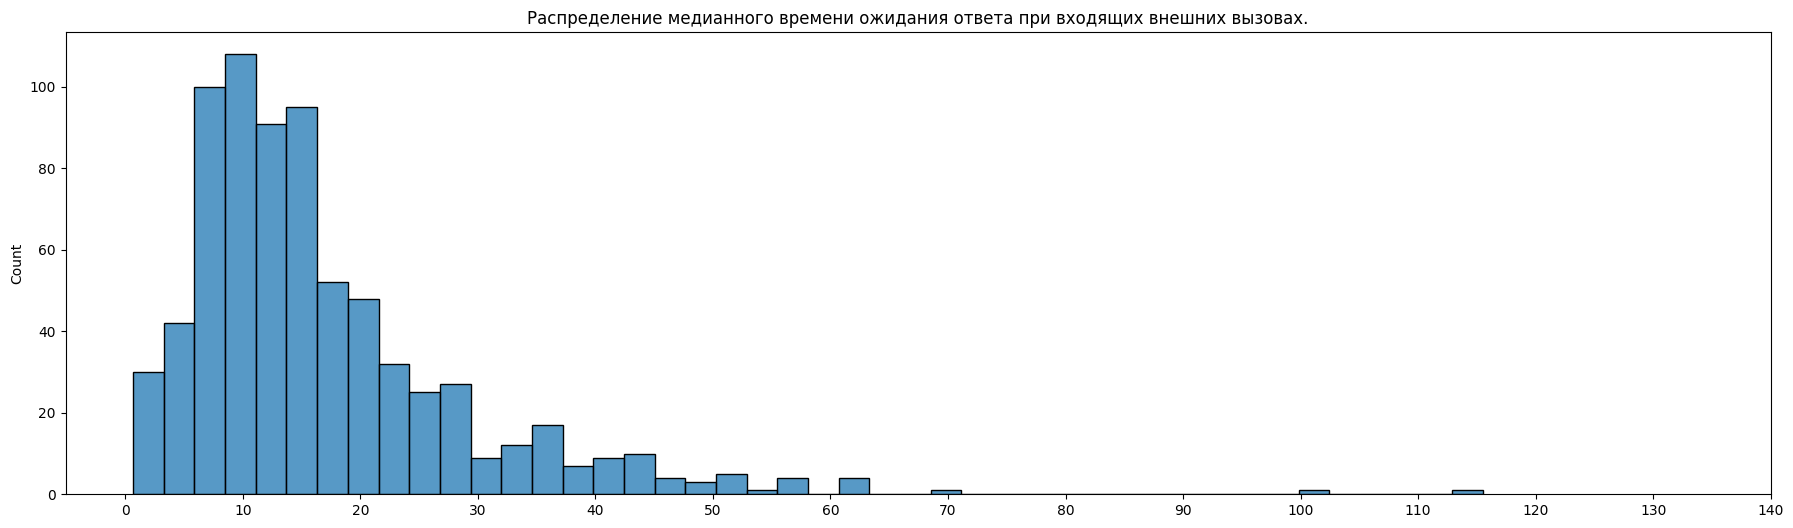

In [50]:
plt.figure(figsize = (22,6))

sns.histplot(time_to_response['median_response_waiting_time'])
plt.title('Распределение медианного времени ожидания ответа при входящих внешних вызовах.')
plt.xlabel('')
plt.xticks(range(0,150,10))

plt.show()

In [51]:
# 3. выделяем неэффективных операторов и добавляем их в общий список

inefficient_operators += list(time_to_response.query('median_response_waiting_time > 60').operator_id)

***3. мало исходящих вывозов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков***

*Сначала определим какие КЦ специализируется на обзвонах, а какие на обработке входящих звонков.*

In [52]:
# 1. считаем общие звонки для каждого КЦ
temp_all = (main_df.groupby('user_id', as_index = False)
                   .direction
                   .count()
                   .rename(columns = {'direction' : 'total_calls_amount'}))

# 2. считаем исходящие звонки для каждого КЦ
temp_out = (main_df.query('direction == "out"')
                   .groupby('user_id', as_index = False)
                   .direction
                   .count()
                   .rename(columns = {'direction' : 'out_calls_amount'}))


# 3. объединяем в одну таблицу и заполняем пропущенные значения нулями
temp_final = temp_all.merge(temp_out, on = 'user_id', how = 'left').fillna(0)

# 4. считаем долю исходящих звонков
temp_final['out_calls_ratio'] = temp_final['out_calls_amount'] / temp_final['total_calls_amount']

*Будем считать, что КЦ специализируется на обзвонах, если процент исходящих звонков > 50.*

In [53]:
# выделим КЦ, специализирущиеся на обзвонах
out_call_centers = list(temp_final.query('out_calls_ratio > 0.5').user_id.unique())

In [54]:
# 1. выделим операторов из КЦ, которые специализируются на обзвонах и посчитаем общее кол-во звонков
temp_all = (main_df.query('user_id in @out_call_centers and operator_id != 0')
                   .groupby('operator_id', as_index = False)
                   .user_id
                   .count()
                   .rename(columns = {'user_id' : 'total_calls'}))

# 2. выделим операторов из КЦ, которые специализируются на обзвонах и посчитаем кол-во исходящих звонков
temp_out = (main_df.query('user_id in @out_call_centers and operator_id != 0 and direction == "out"')
                   .groupby('operator_id', as_index = False)
                   .user_id
                   .count()
                   .rename(columns = {'user_id' : 'out_calls'}))

# 3. объединяем 2 датасета, заполняем пропуски нулями и считаем отношение исходящих звонков
temp_final = temp_all.merge(temp_out, on = 'operator_id', how = 'left').fillna(0)
temp_final['out_calls_ratio'] = temp_final['out_calls'] / temp_final['total_calls']

*Посмотрим на распределение доли исходящих вызовов.*

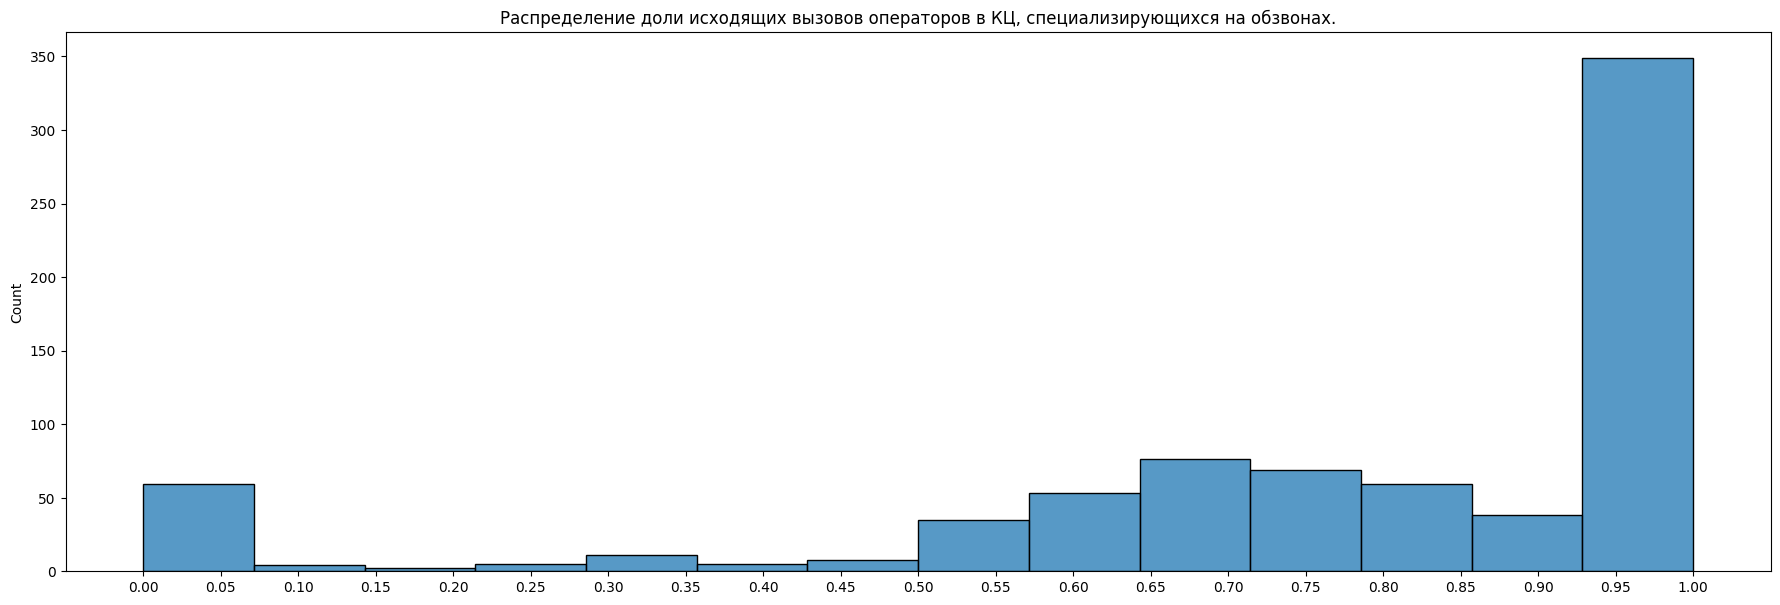

In [55]:
plt.figure(figsize = (22,7))

sns.histplot(data = temp_final['out_calls_ratio'])

plt.title('Распределение доли исходящих вызовов операторов в КЦ, специализирующихся на обзвонах.')
plt.xlabel('')
plt.xticks(np.arange(0, 1.05, 0.05))


plt.show()

*Будем считать, что оператор неэффективен, если доля его исходящих вызовов < 85%.*

In [56]:
inefficient_operators += list(temp_final.query('out_calls_ratio < 0.85').operator_id.unique())

In [57]:
# теперь выделим уникальных операторов, так как в inefficient_operators могут быть дубликаты

unique_inefficient_operators = []

for operator in inefficient_operators:
    if operator not in unique_inefficient_operators:
        unique_inefficient_operators.append(operator)

In [58]:
print(f'Общее кол-во операторов - {main_df.operator_id.unique().shape[0]}.')
print(f'Кол-во неэффективных операторов - {len(unique_inefficient_operators)}.')
print(f'% неэффективных операторов - {round(len(unique_inefficient_operators)/main_df.operator_id.unique().shape[0]*100,2)}%.')

Общее кол-во операторов - 1093.
Кол-во неэффективных операторов - 409.
% неэффективных операторов - 37.42%.


*Посмотрим, в каких КЦ больше всего неэффективных операторов. И какие КЦ больше всего заинтересованы в новом сервисе.*

In [161]:
# 1. считаем кол-во неэффективных операторов для каждого КЦ
call_center_ineffiecient_operators = (main_df.query('operator_id in @unique_inefficient_operators and operator_id != 0')
                                .groupby('user_id', as_index = False)
                                .operator_id
                                .nunique()
                                .rename(columns = {'operator_id' : 'ineffiecient_operators_amount'})
                                .sort_values(by = 'ineffiecient_operators_amount', ascending = False)
                                .reset_index(drop = True))

# 2. считаем общее кол-во операторов для каждого КЦ
call_center_all_operators = (main_df.query('operator_id != 0')
                                    .groupby('user_id', as_index = False)
                                    .operator_id
                                    .nunique()
                                    .rename(columns = {'operator_id' : 'all_operators_amount'})
                                    .sort_values(by = 'all_operators_amount', ascending = False)
                                    .reset_index(drop = True))

# 3. объединяем 2 датасета, заполняем пропуски нулями
call_centers_operators = call_center_all_operators.merge(call_center_ineffiecient_operators, on = 'user_id', how = 'left')
call_centers_operators = call_centers_operators.fillna(0)

# 3. создаём колонку с процентом неэффективных операторов 
call_centers_operators['ineffiecient_operators_ratio'] = (call_centers_operators['ineffiecient_operators_amount']
                                                        / call_centers_operators['all_operators_amount'])

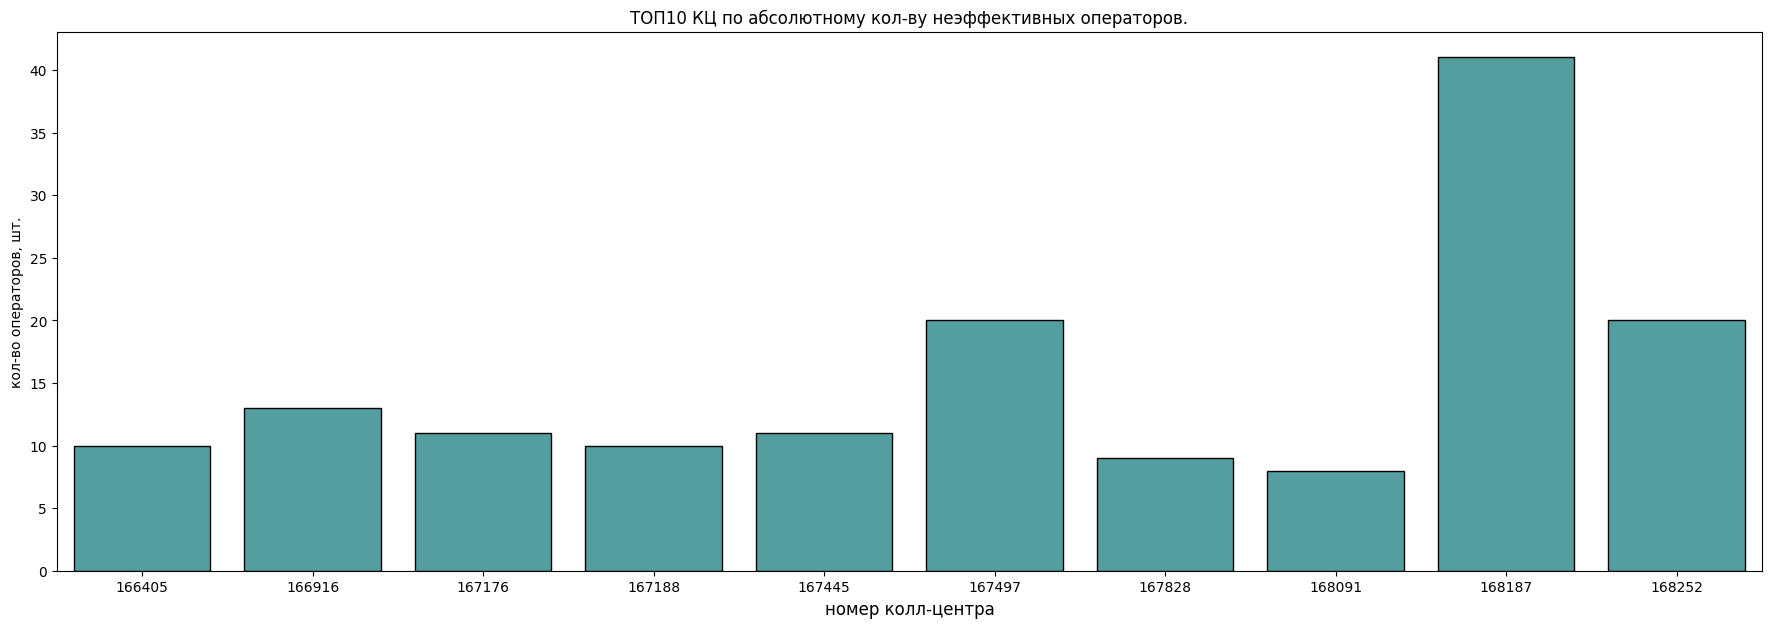

In [162]:
plt.figure(figsize = (22,7))

call_centers_operators = call_centers_operators.sort_values(by = 'ineffiecient_operators_amount', ascending = False)
sns.barplot(data = call_centers_operators.head(10), x = 'user_id', y = 'ineffiecient_operators_amount',
            edgecolor = 'black', color = '#48AAAD')

plt.title('ТОП10 КЦ по абсолютному кол-ву неэффективных операторов.')
plt.xlabel('номер колл-центра', size = 12)
plt.ylabel('кол-во операторов, шт.')

plt.show()

*Будем считать, что КЦ нужен новый сервис для повышения эффективности, если процент неэффективных операторов в кц > 10%.*

In [163]:
percentage = call_centers_operators[call_centers_operators.ineffiecient_operators_ratio > 0.1].shape[0]/call_centers_operators.shape[0]*100
print(f'{percentage}% КЦ нужен новый сервис для повышения эффективности операторов,')
print('так как кол-во неэффектиных операторов в этих КЦ больше 10%.')

40.0% КЦ нужен новый сервис для повышения эффективности операторов,
так как кол-во неэффектиных операторов в этих КЦ больше 10%.


***Итоги определения неэффективных операторов:***
1. *По 3м критериям оценили неэффективных операторов, их оказалось почти 38%*
2. *Нашли КЦ c неэффективыми операторами и посчитали, что 40% КЦ нужен новый сервис для более эффективной работы*
3. *Построили графики и гистограммы для лучшей наглядности данных*

---
### *Проверка статистических гипотез.*

- ***H0*** - *Средняя длительность звонков тарифа A не отличается от тарифа B.*
- ***H1*** - *Средняя длительность звонков тарифа A отличается от тарифа B.*

In [169]:
# задаём значения для проверки гипотезы
average_call_duration_A = main_df.query('tariff_plan == "A"').call_duration
average_call_duration_B = main_df.query('tariff_plan == "B"').call_duration

# определяем уровень статистической значимости
alpha = .05

# используем t-критерий, чтобы посмотреть средние значения двух независимых выборок
results = st.ttest_ind(average_call_duration_A, average_call_duration_B)

if results.pvalue > alpha:
    print('Не можем отвергнуть H0. Средняя длительность звонков тарифа A не отличается от тарифа B.')
else:
    print('Принимаем H1. Средняя длительность звонков тарифа A отличается от тарифа B.')


Принимаем H1. Средняя длительность звонков тарифа A отличается от тарифа B.


- ***H0*** - *Средняя длительность звонков тарифа A не отличается от тарифа C.*
- ***H1*** - *Средняя длительность звонков тарифа A отличается от тарифа C.*

In [170]:
# задаём значения для проверки гипотезы
average_call_duration_A = main_df.query('tariff_plan == "A"').call_duration
average_call_duration_C = main_df.query('tariff_plan == "C"').call_duration

# определяем уровень статистической значимости
alpha = .05

# используем t-критерий, чтобы посмотреть средние значения двух независимых выборок
results = st.ttest_ind(average_call_duration_A, average_call_duration_C)

if results.pvalue > alpha:
    print('Не можем отвергнуть H0. Средняя длительность звонков тарифа A не отличается от тарифа C.')
else:
    print('Принимаем H1. Средняя длительность звонков тарифа A отличается от тарифа C.')


Принимаем H1. Средняя длительность звонков тарифа A отличается от тарифа C.


- ***H0*** - *Кол-во звонков у тарифа А не отличается от  тарифа B*
- ***H1*** - *Кол-во звонков у тарифа А отличается от тарифа B*

In [172]:
# задаем значения для теста
calls_amount_A = main_df.query('tariff_plan == "A"').calls_count
calls_amount_B = main_df.query('tariff_plan == "B"').calls_count

# определяем уровень статистической значимости
alpha = .05

# используем U-критерий Манна-Уитни, чтобы посмотреть на различие параметра
results = st.mannwhitneyu(calls_amount_A, calls_amount_B)

if results.pvalue > alpha:
    print('Не можем отвергнуть H0. Кол-во звонков у тарифа А не отличается от  тарифа B.')
else:
    print('Принимаем H1. Кол-во звонков у тарифа А отличается от тарифа B.')


Принимаем H1. Кол-во звонков у тарифа А отличается от тарифа B.


***Итоги проверки статистических гипотез***
1. *Выяснилось, что средняя длительность звонков тарифа A отличается от тарифа B.*
2. *Выяснилось, что средняя длительность звонков тарифа A отличается от тарифа C.*
3. *Кол-во звонков у тарифа А отличается от тарифа B.*

---
### *Итоговые выводы*
- *Загрузили данные, избавились от дубликатов, заполнили пропуски нулями, избавились от аномалий*
- *Провели исследовательский анализ данных, посчитали кол-во клиентов каждого тарифного плана, выяснили, что почти все регистрации совершаются в будние дни и что у разных тарифов преобладают регистрации в разные дни недели*
- *Определили по 3м критериям неэффективных операторов, их оказалось почти 38%, нашли КЦ и неэффективными операторами, 40% КЦ нужен новый сервис, поэтому стоит им это предложить. Построили графики и гистограммы для наглядности*
- *Проверили статистические гипотезы, оказалось, что средняя длительсть звонков тарифа А отличается от тарифа B и C и что кол-во звонков у тарифа А отличается от тарифа B*
